In [54]:
import os
import math
import ROOT as rt
import numpy as np
import matplotlib.pyplot as plt
import utils 
from ROOT import VecOps
from analysis import (df, df_filtered, tree, HMNCSBR, TRUNCSBR, COLOR_MAP)

name_tag = str(utils.TAG)
print("cwd:", os.getcwd())

cwd: /home/student/projects/optimizing_DEDx_estimator/notebooks


In [55]:
cluster = df.AsNumpy(["cluster_DeDxStrip"])["cluster_DeDxStrip"]

In [56]:

# checking how the TTree arranges the data I need

print(f"number of events:{tree.GetEntries()}\n")

count = 0
for (i, event), (j, tracks) in zip(
      enumerate(tree), 
      enumerate(cluster)
    ):
    if tracks:
        avg = event.DeDx_IhStrip
        for i,track in enumerate(tracks):
            hits = len(track)
            thrshld = 22
            if hits > thrshld:
                print(f"Event ID{event.event} with {len(tracks)} tracks\n Showing only those with hits > {thrshld} : ")
                print(f"\tTrack No.{i+1} with {hits} strip hits: {track}\n Track's Harmonic average = {avg[i]}\n")
        # count += 1
        # if count == 100:
        #     break
    

number of events:7713

Event ID36263 with 1 tracks
 Showing only those with hits > 22 : 
	Track No.1 with 23 strip hits: { 5.26964f, 6.01354f, 5.00183f, 5.30874f, 5.27804f, 6.56701f, 8.34674f, 9.29797f, 7.39553f, 5.33937f, 4.63904f, 5.66134f, 4.69567f, 5.69908f, 9.71308f, 6.32411f, 5.13122f, 5.05548f, 4.80878f, 4.73389f, 5.56630f, 5.81295f, 5.77556f }
 Track's Harmonic average = 5.637402057647705

Event ID42880 with 4 tracks
 Showing only those with hits > 22 : 
	Track No.2 with 26 strip hits: { 9.14398f, 5.98114f, 5.79338f, 6.73284f, 5.57405f, 6.92061f, 9.92679f, 5.16695f, 11.8683f, 8.29845f, 9.01876f, 8.73690f, 6.38828f, 6.02906f, 6.10583f, 6.43450f, 6.04795f, 6.16403f, 5.70021f, 5.89341f, 6.37663f, 6.00926f, 6.29966f, 5.56496f, 6.06761f, 5.17837f }
 Track's Harmonic average = 6.424683570861816

Event ID63017 with 2 tracks
 Showing only those with hits > 22 : 
	Track No.2 with 23 strip hits: { 3.61078f, 3.36644f, 3.52082f, 5.92984f, 3.27378f, 4.72533f, 7.56682f, 3.10628f, 3.27776f, 4

In [57]:
# Event ID42880 with 4 tracks
#  Showing only those with hits > 25 : 
# 	Track No.2 with 26 strip hits: { 9.14398f, 5.98114f, 5.79338f, 6.73284f, 5.57405f, 6.92061f, 9.92679f, 5.16695f, 11.8683f, 8.29845f, 9.01876f, 8.73690f, 6.38828f, 6.02906f, 6.10583f, 6.43450f, 6.04795f, 6.16403f, 5.70021f, 5.89341f, 6.37663f, 6.00926f, 6.29966f, 5.56496f, 6.06761f, 5.17837f }
#  Track's Harmonic average = 6.424683570861816

# Event ID36263 with 1 tracks
#  Showing only those with hits > 22 : 
# 	Track No.1 with 23 strip hits: { 5.26964f, 6.01354f, 5.00183f, 5.30874f, 5.27804f, 6.56701f, 8.34674f, 9.29797f, 7.39553f, 5.33937f, 4.63904f, 5.66134f, 4.69567f, 5.69908f, 9.71308f, 6.32411f, 5.13122f, 5.05548f, 4.80878f, 4.73389f, 5.56630f, 5.81295f, 5.77556f }
#  Track's Harmonic average = 5.637402057647705

# Event ID42880 with 4 tracks
#  Showing only those with hits > 22 : 
# 	Track No.2 with 26 strip hits: { 9.14398f, 5.98114f, 5.79338f, 6.73284f, 5.57405f, 6.92061f, 9.92679f, 5.16695f, 11.8683f, 8.29845f, 9.01876f, 8.73690f, 6.38828f, 6.02906f, 6.10583f, 6.43450f, 6.04795f, 6.16403f, 5.70021f, 5.89341f, 6.37663f, 6.00926f, 6.29966f, 5.56496f, 6.06761f, 5.17837f }
#  Track's Harmonic average = 6.424683570861816

# Event ID63017 with 2 tracks
#  Showing only those with hits > 22 : 
# 	Track No.2 with 23 strip hits: { 3.61078f, 3.36644f, 3.52082f, 5.92984f, 3.27378f, 4.72533f, 7.56682f, 3.10628f, 3.27776f, 4.76402f, 3.20155f, 2.85852f, 2.93486f, 2.85863f, 2.59176f, 2.85845f, 4.40225f, 8.93740f, 10.7485f, 2.36296f, 3.48760f, 2.61089f, 4.44009f }
#  Track's Harmonic average = 3.4507217407226562

# Event ID73523 with 2 tracks
#  Showing only those with hits > 22 : 
# 	Track No.1 with 23 strip hits: { 11.5992f, 9.66067f, 10.0737f, 9.91495f, 9.91482f, 9.15228f, 8.07172f, 11.0589f, 9.50191f, 10.5506f, 9.59708f, 8.61192f, 8.45315f, 9.78804f, 7.00023f, 6.72602f, 6.82396f, 6.41209f, 6.15704f, 7.68714f, 6.21618f, 6.47145f, 6.00068f }
#  Track's Harmonic average = 7.973351001739502

In [58]:
target_event = 36263      # the event you asked for
target_hits  = 23         # track must have exactly 23 strip hits
t = []
# --- loop once over the tree ------------------------------------------------
for evt in tree:                       # evt is the TTree reader object
    if evt.event != target_event:      # adjust branch name if not 'event'
        continue

    # evt.cluster_DeDxStrip is a vector<vector<float>>
    for idx, track in enumerate(evt.cluster_DeDxStrip):
        if len(track) == target_hits:
            t = track
            print(f"Event {target_event}  Track {idx+1}  "
                  f"{len(track)} hits\n{list(track)}")
            break     # found it, exit inner loop
    break             # event found, exit outer loop

print(t)

Event 36263  Track 1  23 hits
[5.269637584686279, 6.013542652130127, 5.001830577850342, 5.308736801147461, 5.278040409088135, 6.567014694213867, 8.346741676330566, 9.297966003417969, 7.395531177520752, 5.339369297027588, 4.639042854309082, 5.661344051361084, 4.695667266845703, 5.699080944061279, 9.713075637817383, 6.324105262756348, 5.131218433380127, 5.055481910705566, 4.808780193328857, 4.73388671875, 5.566300392150879, 5.812950611114502, 5.775557041168213]
{ 5.26964f, 6.01354f, 5.00183f, 5.30874f, 5.27804f, 6.56701f, 8.34674f, 9.29797f, 7.39553f, 5.33937f, 4.63904f, 5.66134f, 4.69567f, 5.69908f, 9.71308f, 6.32411f, 5.13122f, 5.05548f, 4.80878f, 4.73389f, 5.56630f, 5.81295f, 5.77556f }


****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      1.49557
NDf                       =            3
Edm                       =  7.70136e-06
NCalls                    =          209
Constant                  =       117.53   +/-   114.467     
MPV                       =      5.00131   +/-   0.230341    
Sigma                     =     0.238047   +/-   0.14861      	 (limited)


Warning in <TFile::Append>: Replacing existing TH1: h (Potential memory leak).


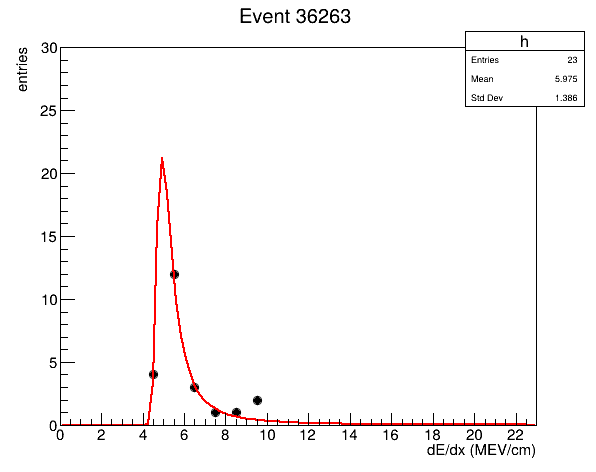

In [62]:
# track now holds the list / RVec<float> of 23 strip charges
charges = list(t)          

# 1) pick sensible histogram limits -----------------------------
qmin, qmax = min(charges), max(charges)
lo  = 0.8 * qmin              
hi  = 1.1 * qmax               
nbins = 23                     

# 2) fill the histogram -----------------------------------------
h = rt.TH1F("h", f"Event {target_event};dE/dx (MEV/cm);entries", nbins, 0, nbins)
for q in charges:
    h.Fill(q)

# 3) draw (and optionally fit) ----------------------------------
c = rt.TCanvas("c", "", 600, 500)
h.Draw("P")
h.SetMarkerStyle(20)
h.SetMaximum(30)

# optional Landau fit:
h.Fit("landau")              # remove 'Q' if you want the fit print-out
c.Draw()



Warning in <TFile::Append>: Replacing existing TH1: h1 (Potential memory leak).


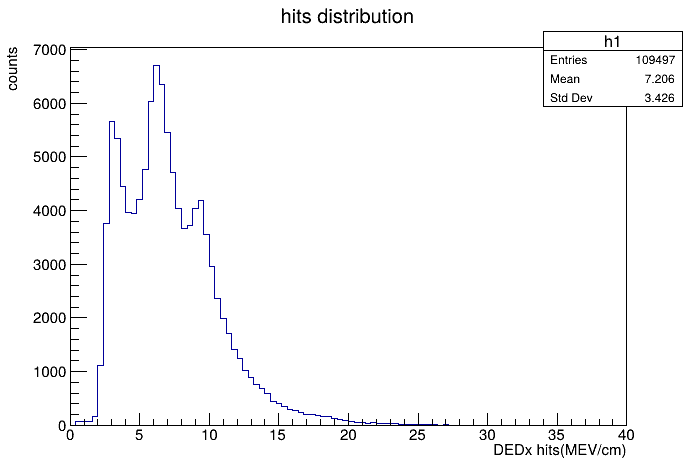

In [60]:
h1 = rt.TH1F("h1", " hits distribution; DEDx hits(MEV/cm); counts", 100, 0, 40)

for tracks in cluster:
  for track in tracks:  
    for hit in track:
      h1.Fill(hit)

c = rt.TCanvas()
h1.Draw()
c.Draw()

26
{ 9.14398f, 5.98114f, 5.79338f, 6.73284f, 5.57405f, 6.92061f, 9.92679f, 5.16695f, 11.8683f, 8.29845f, 9.01876f, 8.73690f, 6.38828f, 6.02906f, 6.10583f, 6.43450f, 6.04795f, 6.16403f, 5.70021f, 5.89341f, 6.37663f, 6.00926f, 6.29966f, 5.56496f, 6.06761f, 5.17837f }
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      1.12899
NDf                       =            2
Edm                       =  8.43318e-06
NCalls                    =          125
Constant                  =       75.871   +/-   29.6076     
MPV                       =      6.15598   +/-   0.188818    
Sigma                     =     0.451741   +/-   0.181882     	 (limited)


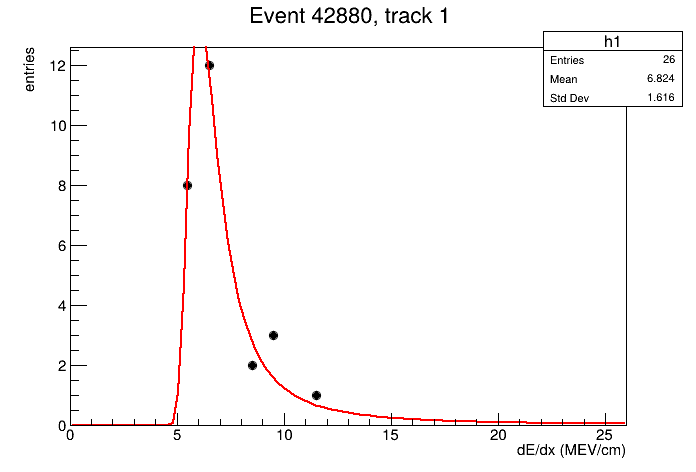

In [ ]:

thrshld = 23

for event, (j, tracks) in zip(
      tree, 
      enumerate(cluster)
    ):
  hists = []
  for i, track in enumerate(tracks): 
    if len(track) > thrshld:
      hist = rt.TH1F(f"h{i}", f"Event {event.event}, track {i};dE/dx (MEV/cm);entries", len(track), 0, len(track))
      f = rt.TCanvas()
      print(len(track))
    
      for hit in track:
          hist.Fill(hit)
      hist.Draw("P")
      hist.SetMarkerStyle(20)
      hist.Fit("landau")
      f.Draw("same")
      print(track)
    #print(track)
    
    
    #TODO: FIT PARAMETERS AND HARMONIC FOR EACH TRACK IN A TUPLE AND SAVE THAT INTO AN ARRAY, draw a 2d corelation histogram btween the two tuples
    #TODO: for about 10 fits, save images, and 